#CREATING & EXPLORING DATASET


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 35.5 MB/s eta 0:00:00


In [4]:
## Importing Libraries
import shutil
import os
import cv2
import matplotlib.pyplot as plt
import zipfile
from tqdm import tqdm
from PIL import Image,ImageOps

import numpy as np
import re
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## DATA COLLECTION

In [6]:
shutil.copyfile('/content/drive/MyDrive/Camouflage_Detection/kaggle.json','/content/kaggle.json')

'/content/kaggle.json'

In [7]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! kaggle datasets download -d boatshuai/cod10k-v3

Dataset URL: https://www.kaggle.com/datasets/boatshuai/cod10k-v3
License(s): apache-2.0
100% 2.25G/2.26G [00:38<00:00, 133MB/s]
100% 2.26G/2.26G [00:38<00:00, 63.2MB/s]


### Dataset was taken from kaggle.
Name:- boatshuai/cod10k-v3

Link:- https://www.kaggle.com/datasets/boatshuai/cod10k-v3

In [8]:
with zipfile.ZipFile('/content/cod10k-v3.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [9]:
## Defining Functions

def load_images_from_folder_with_filenames(folder_path, filenames):
    images = []
    for filename in tqdm(filenames, desc=f"Loading images from {folder_path}"):
        img_path = os.path.join(folder_path, filename)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            if img is not None:
                images.append(np.array(img))
    return np.array(images)

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


## YOLOv8

In [ ]:
input_dir = '/content/COD10K-v3/Train/GT_Object'
output_dir = '/content/COD10K-v3/Train/labels'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
for j in tqdm(os.listdir(input_dir),"Processing"):
    image_path = os.path.join(input_dir, j)
    # load the binary mask and get its contours
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    H, W = mask.shape
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # convert the contours to polygons
    polygons = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 200:
            polygon = []
            for point in cnt:
                x, y = point[0]
                polygon.append(x / W)
                polygon.append(y / H)
            polygons.append(polygon)

    # print the polygons
    with open('{}.txt'.format(os.path.join(output_dir, j)[:-4]), 'w') as f:
        for polygon in polygons:
            for p_, p in enumerate(polygon):
                if p_ == len(polygon) - 1:
                    f.write('{}\n'.format(p))
                elif p_ == 0:
                    f.write('0 {} '.format(p))
                else:
                    f.write('{} '.format(p))

        f.close()

Processing: 100%|██████████| 6000/6000 [00:48<00:00, 122.62it/s]


In [ ]:
directory_path = '/content/COD10K-v3/Train/labels'

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path) and filename.endswith(('.txt')) and os.stat(file_path).st_size == 0:
        os.remove(file_path)
        image_file_path=os.path.join('/content/COD10K-v3/Train/Image',filename.split(".")[0]+".jpg")
        if not os.path.exists(image_file_path):
          image_file_path=os.path.join('/content/COD10K-v3/Train/Image',filename.split(".")[0]+".png")
        os.remove(image_file_path)


In [ ]:
old_dataset_path='/content/COD10K-v3/Train'
old_images_path='/content/COD10K-v3/Train/Image'
old_labels_path='/content/COD10K-v3/Train/labels'

Dataset_path='/content/Dataset'
images_path='/content/Dataset/images'
labels_path='/content/Dataset/labels'
train_images_path='/content/Dataset/images/train'
train_labels_path='/content/Dataset/labels/train'
val_images_path='/content/Dataset/images/val'
val_labels_path='/content/Dataset/labels/val'

os.mkdir(Dataset_path)
os.mkdir(images_path)
os.mkdir(labels_path)
os.mkdir(train_images_path)
os.mkdir(train_labels_path)
os.mkdir(val_images_path)
os.mkdir(val_labels_path)

number_of_images=len(os.listdir(old_images_path))
train_val_split_ratio=0.8

file_name=sorted_alphanumeric(os.listdir(old_images_path))
train_Image_files=file_name[:int(number_of_images*train_val_split_ratio)]
train_mask_files = [file.split('.')[0] + '.txt' for file in train_Image_files]
val_Image_files=file_name[int(number_of_images*train_val_split_ratio):number_of_images]
val_mask_files = [file.split('.')[0] + '.txt' for file in val_Image_files]




for filename in tqdm(train_Image_files,"Processing Train Data"):
  ## For Image Files
  input_image_file_path=os.path.join(old_images_path,filename)
  output_image_file_path=os.path.join(train_images_path,filename)
  shutil.copyfile(input_image_file_path,output_image_file_path)

for filename in tqdm(val_Image_files,"Processing val Data"):
  ## For Image Files
  input_image_file_path=os.path.join(old_images_path,filename)
  output_image_file_path=os.path.join(val_images_path,filename)
  shutil.copyfile(input_image_file_path,output_image_file_path)

for filename in tqdm(train_mask_files,"Processing Train Data"):
  ## For Mask Files
  input_mask_file_path=os.path.join(old_labels_path,filename)
  output_mask_file_path=os.path.join(train_labels_path,filename)
  shutil.copyfile(input_mask_file_path,output_mask_file_path)

for filename in tqdm(val_mask_files,"Processing val Data"):
  ## For Mask Files
  input_mask_file_path=os.path.join(old_labels_path,filename)
  output_mask_file_path=os.path.join(val_labels_path,filename)
  shutil.copyfile(input_mask_file_path,output_mask_file_path)


Processing val Data: 100%|██████████| 608/608 [00:00<00:00, 1641.40it/s]


In [ ]:
%%writefile data.yaml
path: /content/Dataset
train: /content/Dataset/images/train
val: /content/Dataset/images/val

nc: 1
names: ['camouflage']

Overwriting data.yaml


In [ ]:
model=YOLO('yolov8n-seg.pt')
model.train(data='/content/data.yaml',epochs=50)

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

train: Scanning /content/Dataset/labels/train... 2430 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2430/2430 [00:03<00:00, 643.19it/s]


train: New cache created: /content/Dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/Dataset/labels/val... 608 images, 0 backgrounds, 0 corrupt: 100%|██████████| 608/608 [00:02<00:00, 281.17it/s]

val: New cache created: /content/Dataset/labels/val.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.18G       1.85      3.779      2.769      1.726         41        640: 100%|██████████| 152/152 [01:31<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.56it/s]


                   all        608       1190      0.154      0.146     0.0663     0.0214      0.181      0.111     0.0535     0.0174

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.75G      2.093      3.937      2.723      1.906         49        640: 100%|██████████| 152/152 [01:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]


                   all        608       1190       0.13      0.161     0.0574     0.0189      0.149      0.084     0.0385      0.012

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.19G      2.161      4.043      2.716      1.969         47        640: 100%|██████████| 152/152 [01:18<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.44it/s]


                   all        608       1190       0.22      0.169     0.0835       0.03      0.205      0.116     0.0491      0.015

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.79G      2.163      4.112      2.704      1.991         86        640: 100%|██████████| 152/152 [01:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.76it/s]


                   all        608       1190      0.176      0.189      0.085     0.0327      0.198      0.129     0.0622     0.0191

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50       3.6G      2.084      3.933      2.601      1.906         34        640: 100%|██████████| 152/152 [01:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.71it/s]


                   all        608       1190      0.197      0.211     0.0937     0.0352      0.199      0.164      0.075     0.0249

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.52G      2.058      3.864      2.541      1.883         73        640: 100%|██████████| 152/152 [01:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


                   all        608       1190      0.204      0.202      0.104     0.0455       0.23      0.174     0.0918     0.0357

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.09G      2.044      3.818      2.498      1.839         37        640: 100%|██████████| 152/152 [01:21<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]


                   all        608       1190      0.237      0.205      0.125     0.0478      0.246      0.171     0.0995     0.0369

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.17G      1.981      3.721      2.441      1.811         71        640: 100%|██████████| 152/152 [01:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]

                   all        608       1190      0.297      0.228      0.162     0.0604      0.324      0.211       0.15     0.0553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50       3.7G      1.945      3.713      2.421      1.785         52        640: 100%|██████████| 152/152 [01:21<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]


                   all        608       1190      0.358      0.233      0.195     0.0804       0.36      0.196       0.16     0.0605

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.01G      1.931      3.664      2.396      1.776         54        640: 100%|██████████| 152/152 [01:21<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]


                   all        608       1190      0.374      0.252      0.206     0.0874      0.388      0.224      0.185     0.0722

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.51G      1.897      3.572      2.338      1.755         55        640: 100%|██████████| 152/152 [01:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.50it/s]


                   all        608       1190      0.344      0.251      0.195     0.0779      0.312       0.22      0.171     0.0638

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.42G      1.856      3.548      2.294      1.725         86        640: 100%|██████████| 152/152 [01:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.85it/s]

                   all        608       1190      0.401      0.279      0.236      0.104      0.442      0.266      0.228     0.0943



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.02G      1.847        3.5      2.275      1.709         92        640: 100%|██████████| 152/152 [01:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]


                   all        608       1190      0.424      0.271      0.229        0.1      0.477      0.245      0.222     0.0889

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.32G      1.816      3.441      2.207      1.687         46        640: 100%|██████████| 152/152 [01:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.76it/s]

                   all        608       1190      0.342      0.259      0.213     0.0993      0.423      0.231      0.203     0.0903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.82G      1.797      3.406      2.202      1.686         61        640: 100%|██████████| 152/152 [01:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.03it/s]


                   all        608       1190      0.471      0.308       0.28      0.121      0.434      0.277      0.237      0.102

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50       3.9G       1.79      3.398      2.166      1.676         71        640: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:16<00:00,  1.16it/s]


                   all        608       1190      0.391      0.288      0.237      0.108      0.423      0.271      0.234        0.1

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.37G      1.742      3.324      2.139      1.653         44        640: 100%|██████████| 152/152 [01:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


                   all        608       1190      0.404      0.277      0.251      0.118      0.439      0.244      0.225      0.102

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.71G      1.761      3.302      2.136      1.662         57        640: 100%|██████████| 152/152 [01:18<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]

                   all        608       1190      0.423      0.298      0.265      0.125      0.448      0.261      0.235      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.23G      1.748      3.324      2.102      1.631         33        640: 100%|██████████| 152/152 [01:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]

                   all        608       1190      0.437      0.293      0.278       0.14      0.508      0.239      0.244      0.109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.3G      1.725       3.31      2.074      1.627         39        640: 100%|██████████| 152/152 [01:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]

                   all        608       1190      0.439      0.297      0.279      0.127      0.489      0.266      0.259      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50       3.7G      1.718       3.28      2.043      1.621         60        640: 100%|██████████| 152/152 [01:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.51it/s]


                   all        608       1190      0.417      0.277      0.248      0.111      0.445      0.248      0.223     0.0968

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.75G      1.705      3.208      2.031      1.605        100        640: 100%|██████████| 152/152 [01:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]

                   all        608       1190      0.494      0.318      0.306       0.14      0.527      0.282      0.264      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50       3.5G      1.677      3.195      1.999      1.588         33        640: 100%|██████████| 152/152 [01:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.51it/s]

                   all        608       1190      0.454      0.302      0.282      0.129      0.452      0.286      0.267      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50       3.7G      1.671        3.2      1.947      1.574         44        640: 100%|██████████| 152/152 [01:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]

                   all        608       1190      0.469      0.291      0.288      0.147      0.539      0.273      0.276      0.133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.66G      1.646      3.126      1.922      1.572         71        640: 100%|██████████| 152/152 [01:23<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.45it/s]

                   all        608       1190      0.443      0.275      0.265      0.129      0.486      0.278      0.269      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.61G      1.603      3.063      1.903      1.554         75        640: 100%|██████████| 152/152 [01:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.90it/s]

                   all        608       1190      0.503      0.298      0.313      0.153      0.526      0.294      0.297       0.14



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50       3.7G      1.616      3.053      1.901      1.552         58        640: 100%|██████████| 152/152 [01:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


                   all        608       1190      0.526      0.305      0.313      0.154      0.548      0.304      0.305      0.138

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.71G      1.628      3.072      1.871      1.547         54        640: 100%|██████████| 152/152 [01:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.67it/s]

                   all        608       1190      0.552      0.315      0.328      0.165      0.542      0.303        0.3      0.138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.58G      1.585       3.01      1.841      1.519         59        640: 100%|██████████| 152/152 [01:21<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.98it/s]


                   all        608       1190      0.548      0.318      0.336      0.174      0.582      0.312      0.327      0.154

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.02G      1.565          3      1.797      1.501         69        640: 100%|██████████| 152/152 [01:16<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]

                   all        608       1190      0.523      0.324       0.33      0.173       0.54       0.29      0.296      0.145



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.91G      1.578      2.999      1.809        1.5         42        640: 100%|██████████| 152/152 [01:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]

                   all        608       1190      0.546      0.324      0.326      0.172      0.569      0.316      0.315      0.157



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.63G      1.582      3.006      1.804      1.512        121        640: 100%|██████████| 152/152 [01:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.51it/s]

                   all        608       1190      0.566      0.317      0.335      0.169      0.582      0.305      0.314      0.144



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.75G      1.548      2.927      1.769      1.489         50        640: 100%|██████████| 152/152 [01:21<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all        608       1190      0.486      0.293      0.295       0.15      0.494      0.294      0.288      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.35G      1.517      2.891      1.745      1.485         42        640: 100%|██████████| 152/152 [01:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]


                   all        608       1190      0.578      0.294      0.322      0.163      0.602      0.288      0.308      0.148

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.56G      1.528      2.899      1.719      1.468         52        640: 100%|██████████| 152/152 [01:17<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.85it/s]

                   all        608       1190      0.556      0.318      0.331      0.175      0.528      0.302      0.304      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.82G      1.507      2.891      1.684      1.453         42        640: 100%|██████████| 152/152 [01:18<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.73it/s]


                   all        608       1190      0.579      0.322      0.344       0.18      0.587      0.328       0.34      0.165

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.62G      1.497      2.862      1.677      1.457        107        640: 100%|██████████| 152/152 [01:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]

                   all        608       1190      0.623       0.34      0.369      0.194      0.642       0.34      0.363      0.168



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.66G      1.475      2.842      1.651      1.441         72        640: 100%|██████████| 152/152 [01:18<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.72it/s]


                   all        608       1190        0.6      0.329      0.355      0.179      0.588      0.323      0.336      0.161

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.18G      1.474      2.799       1.64      1.437         50        640: 100%|██████████| 152/152 [01:15<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]

                   all        608       1190      0.528      0.331      0.348      0.177      0.608      0.303      0.337       0.16



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.32G       1.46      2.753      1.614      1.441         61        640: 100%|██████████| 152/152 [01:16<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]

                   all        608       1190      0.551      0.348      0.354      0.185      0.577      0.331      0.338      0.164


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.94G      1.521      2.736      1.688      1.528         30        640: 100%|██████████| 152/152 [01:11<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]

                   all        608       1190      0.558      0.334       0.36      0.187      0.534      0.339      0.345      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.82G      1.498      2.664      1.601      1.514         25        640: 100%|██████████| 152/152 [01:06<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]

                   all        608       1190      0.572      0.339      0.363      0.187      0.587      0.333      0.357      0.174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.31G      1.482      2.663      1.558      1.488         36        640: 100%|██████████| 152/152 [01:07<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.59it/s]

                   all        608       1190      0.536      0.345      0.353      0.185      0.551      0.341      0.343       0.17



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.67G      1.463      2.593      1.505      1.486         23        640: 100%|██████████| 152/152 [01:07<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        608       1190      0.541      0.351      0.368      0.193      0.539      0.334      0.345      0.169



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.48G      1.451      2.594        1.5      1.476         39        640: 100%|██████████| 152/152 [01:09<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.48it/s]

                   all        608       1190      0.546      0.338      0.364      0.194      0.567      0.322      0.346      0.166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.48G      1.425      2.574      1.464      1.449         29        640: 100%|██████████| 152/152 [01:11<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.47it/s]

                   all        608       1190      0.517      0.352      0.367      0.197      0.591      0.336      0.359      0.177



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.67G      1.422      2.533      1.427      1.448         22        640: 100%|██████████| 152/152 [01:10<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.58it/s]

                   all        608       1190       0.59      0.348      0.372      0.201       0.59      0.344      0.359      0.177



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.63G      1.407      2.523      1.429      1.438         26        640: 100%|██████████| 152/152 [01:10<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.01it/s]

                   all        608       1190      0.589      0.351      0.377      0.199      0.592      0.341      0.362      0.179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.34G      1.384      2.516      1.398       1.41         44        640: 100%|██████████| 152/152 [01:14<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]

                   all        608       1190      0.554      0.341      0.379      0.206      0.619      0.335      0.371      0.186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.77G      1.375      2.487      1.389      1.417         29        640: 100%|██████████| 152/152 [01:17<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]

                   all        608       1190      0.565      0.333       0.37      0.202      0.604      0.333      0.361       0.18



50 epochs completed in 1.251 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


                   all        608       1190      0.553       0.34      0.378      0.206      0.614      0.336      0.371      0.187
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a207e748520>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

In [ ]:
shutil.copytree('/content/runs', '/content/drive/MyDrive/Camouflage_Detection/runs')

'/content/drive/MyDrive/Projects/DL/Camouflage_Segmentation/runs'

In [10]:
model = YOLO('/content/drive/MyDrive/Camouflage_Detection/runs/segment/train/weights/best.pt')

In [11]:
shutil.copytree('/content/drive/MyDrive/Camouflage_Detection/runs','/content/runs')
shutil.copytree('/content/drive/MyDrive/Camouflage_Detection/Final_Test','/content/Final_Test')

'/content/Final_Test'

In [12]:
def find_result(image_path,model):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  result=model.predict(image_path)
  mask = result[0].masks[0].data[0].cpu().numpy()
  mask=cv2.resize(mask,(256,256))
  return mask


image 1/1 /content/Final_Test/Images/COD10K-CAM-1-Aquatic-10-LeafySeaDragon-421.jpg: 448x640 1 camouflage, 420.5ms
Speed: 15.4ms preprocess, 420.5ms inference, 32.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/Final_Test/Images/COD10K-CAM-1-Aquatic-10-LeafySeaDragon-427.jpg: 480x640 2 camouflages, 240.2ms
Speed: 4.2ms preprocess, 240.2ms inference, 8.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/Final_Test/Images/COD10K-CAM-1-Aquatic-10-LeafySeaDragon-428.jpg: 512x640 1 camouflage, 227.4ms
Speed: 2.5ms preprocess, 227.4ms inference, 3.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/Final_Test/Images/COD10K-CAM-1-Aquatic-11-Octopus-431.jpg: 448x640 1 camouflage, 181.8ms
Speed: 2.4ms preprocess, 181.8ms inference, 3.8ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/Final_Test/Images/COD10K-CAM-1-Aquatic-11-Octopus-439.jpg: 448x640 1 camouflage, 181.1ms
Speed: 2.8ms preprocess, 181.1ms infere

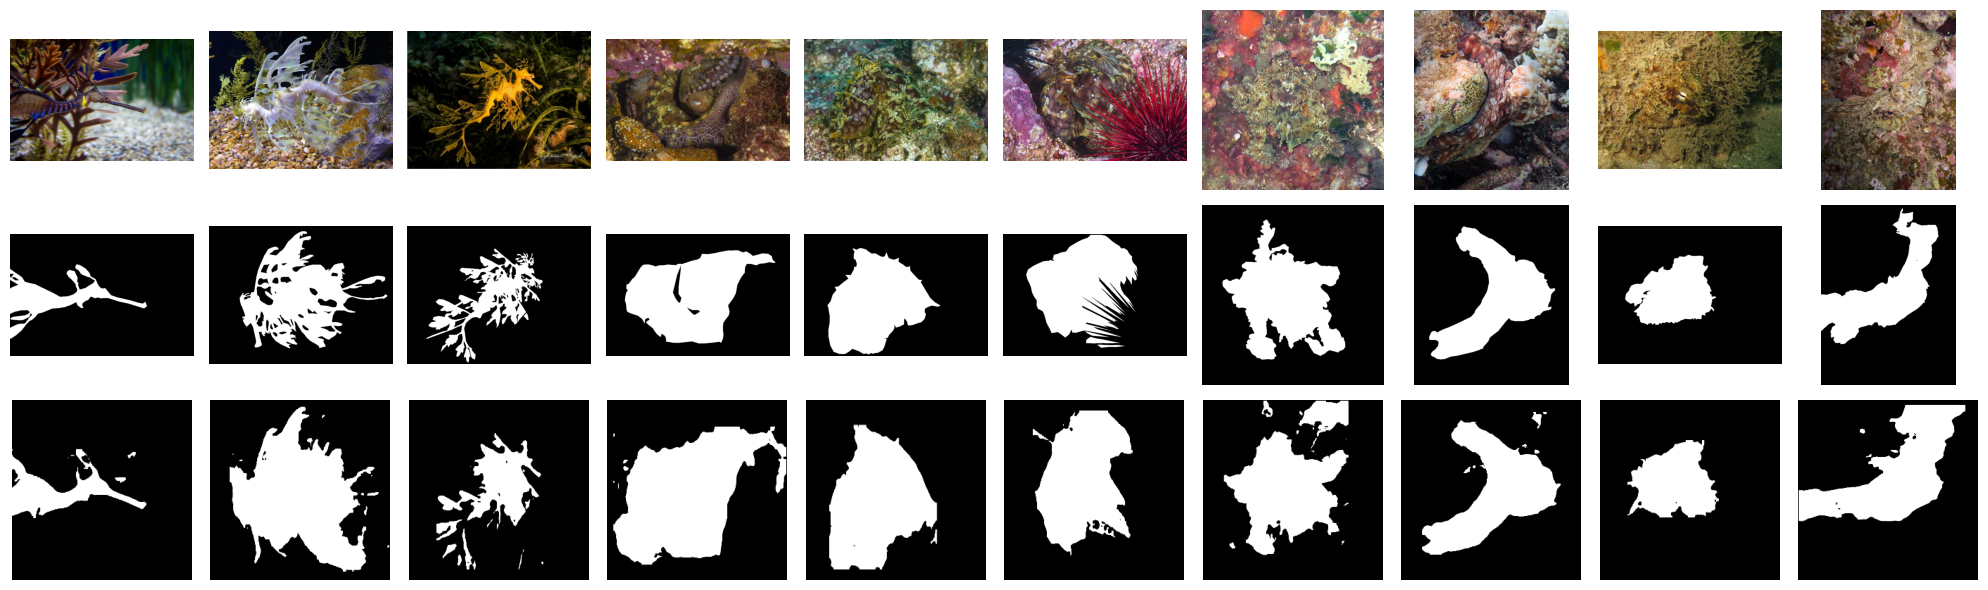

In [14]:

image_dir = '/content/Final_Test/Images'
mask_dir = '/content/Final_Test/Mask'

image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
image_files = sorted_alphanumeric(image_files)[5:15]

fig, axes = plt.subplots(3, 10, figsize=(20, 6))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, image_file[:-4] + '.png')

    try:
      img = cv2.imread(image_path)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      prediction = find_result(image_path, model)

      axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      axes[0, i].axis('off')
      axes[1, i].imshow(mask, cmap='gray')
      axes[1, i].axis('off')
      axes[2, i].imshow(prediction, cmap='gray')
      axes[2, i].axis('off')

    except Exception as e:
      print(f"Error processing {image_file}: {e}")

plt.tight_layout()
plt.show()